# Introduction

**Objectifs du projet :**
- réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une description textuelle et/ou une image , pour l'automatisation de l'attribution de la catégorie de l'article ;
- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité (comme l'ARI) entre les catégories réelles et les clusters ;
- entraîner des modèles de NLP et de vision par ordinateur pour classifier les articles.

Afin d’extraire les features texte, nous allons mettre en oeuvre plusieurs approches : 

- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

Pour extraire les features image, nous allons utiliser deux approches :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

Les parties 2 à 5 du notebook sont consacrés à l'exploration des données, la partie 5 au pré-traitement des données textuelles, les parties 6 à 10 à l'analyse de ces données, et les parties 11 et 12 à l'analyse des données images.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words, stopwords

from wordcloud import WordCloud

import string

In [206]:
df = pd.read_csv('./data/flipkart_com-ecommerce_sample_1050.csv')
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

# Premier coup d'oeil

## Structure

In [207]:
df.sample(5, random_state=0)

uniq_id            crawl_timestamp  \
743  d47f1cb78db4a23e2516e2d34da34c8a  2015-12-12 11:46:53 +0000   
656  260c74b5a09272dec1a8207db3541a0d  2015-12-31 09:19:31 +0000   
704  7915f1c0703450d4b1446c06066d9a59  2016-01-01 19:37:22 +0000   
738  5fdb912462da9891e5b21c677ceb15e4  2016-06-26 09:25:14 +0000   
496  087e83a2406dc98d941b8555356da477  2016-01-07 05:50:25 +0000   

                                           product_url  \
743  http://www.flipkart.com/nutcase-sticker-wrap-d...   
656  http://www.flipkart.com/bornbabykids-cotton-ba...   
704  http://www.flipkart.com/home-originals-abstrac...   
738  http://www.flipkart.com/brass-gift-center-show...   
496  http://www.flipkart.com/sonata-7016ym04-watch/...   

                                          product_name  \
743  Nutcase Sticker Wrap Design - Pineapple 800 ml...   
656                     BornBabyKids Cotton Bath Towel   
704  Home Originals Abstract, Abstract Double Blank...   
738              brass gift center Showpiece  -  48 cm   
496                              Sonata 7016YM04 Watch   

                                 product_category_tree               pid  \
743  ["Kitchen & Dining >> Containers & Bottles >> ...  BOTEANCH6ZZZHJVD   
656  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEE2FFGXVH3MFW   
704  ["Home Furnishing >> Bed Linen >> Blankets, Qu...  BLAEE2GJHZHDRDNK   
738  ["Home Decor & Festive Needs >> Religion & Dev...  SHIEJY5HPVJT9MUE   
496  ["Watches >> Wrist Watches >> Sonata Wrist Wat...  WATDZ2ZQE9C7GQVK   

     retail_price  discounted_price                                 image  \
743         799.0             399.0  d47f1cb78db4a23e2516e2d34da34c8a.jpg   
656         649.0             589.0  260c74b5a09272dec1a8207db3541a0d.jpg   
704        2999.0            1299.0  7915f1c0703450d4b1446c06066d9a59.jpg   
738        7999.0            4550.0  5fdb912462da9891e5b21c677ceb15e4.jpg   
496         840.0             789.0  087e83a2406dc98d941b8555356da477.jpg   

     is_FK_Advantage_product  \
743                    False   
656                    False   
704                    False   
738                    False   
496                    False   

                                           description       product_rating  \
743  Nutcase Sticker Wrap Design - Pineapple 800 ml...  No rating available   
656  Buy BornBabyKids Cotton Bath Towel at Rs. 589 ...  No rating available   
704  Buy Home Originals Abstract, Abstract Double B...  No rating available   
738  Key Features of brass gift center Showpiece  -...  No rating available   
496  Sonata 7016YM04 Watch - Buy Sonata 7016YM04 Wa...  No rating available   

          overall_rating              brand  \
743  No rating available                NaN   
656  No rating available       BornBabyKids   
704  No rating available     Home Originals   
738  No rating available  brass gift center   
496  No rating available                NaN   

                                product_specifications  
743  {"product_specification"=>[{"key"=>"Body Mater...  
656  {"product_specification"=>[{"key"=>"Hooded", "...  
704  {"product_specification"=>[{"key"=>"Brand", "v...  
738  {"product_specification"=>[{"key"=>"Brand", "v...  
496  {"product_specification"=>{"key"=>"Style Code"...

Les colonnes à utiliser pour l'analyse textuelle seront les clonnes **description** et éventuellement **product_name** pour le bag-of-words. <br>
La colonne **product_category_tree** va nous servir à étiqueter les données.

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [209]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [210]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [211]:
# Nombre de valeurs uniques des noms de produits
len(df['product_name'].unique())

1050

In [212]:
# Nombre de valeurs uniques des noms de produits une fois mis en minuscules
len(df['product_name'].str.lower().unique())

1048

## NaNs et doublons

In [213]:
df.isna().sum().sort_values(ascending=False)[:5]

brand                     338
retail_price                1
discounted_price            1
product_specifications      1
uniq_id                     0
dtype: int64

In [214]:
df.duplicated().sum()

0

In [215]:
# Regardons le nombre de doublons pour chaque colonne
n_duplicates = {}
for col in df.columns:
    if df[col].dtype == "object":
        # on met tout en minuscule avant de regarder les doublons
        n_duplicates[col] = df[col].str.lower().duplicated().sum()
        continue
    n_duplicates[col] = df.duplicated(subset=col).sum()

pd.DataFrame(data={"# duplicates": n_duplicates})

# duplicates
brand                             564
crawl_timestamp                   901
description                         0
discounted_price                  625
image                               0
is_FK_Advantage_product          1048
overall_rating                   1023
pid                                 0
product_category_tree             411
product_name                        2
product_rating                   1023
product_specifications             65
product_url                         0
retail_price                      695
uniq_id                             0

## Inspection des données

In [216]:
df.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [217]:
df.describe(include=object)

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   

                                       image  \
count                                   1050   
unique                                  1050   
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                                       1   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

             product_rating       overall_rating         brand  \
count                  1050                 1050           712   
unique                   27                   27           490   
top     No rating available  No rating available  PRINT SHAPES   
freq                    889                  889            11   

                                   product_specifications  
count                                                1049  
unique                                                984  
top     {"product_specification"=>[{"key"=>"Type", "va...  
freq                                                   22

In [218]:
df.loc[0]

uniq_id                                     55b85ea15a1536d46b7190ad6fff8ce7
crawl_timestamp                                    2016-04-30 03:22:56 +0000
product_url                http://www.flipkart.com/elegance-polyester-mul...
product_name               Elegance Polyester Multicolor Abstract Eyelet ...
product_category_tree      ["Home Furnishing >> Curtains & Accessories >>...
pid                                                         CRNEG7BKMFFYHQ8Z
retail_price                                                          1899.0
discounted_price                                                       899.0
image                                   55b85ea15a1536d46b7190ad6fff8ce7.jpg
is_FK_Advantage_product                                                False
description                Key Features of Elegance Polyester Multicolor ...
product_rating                                           No rating available
overall_rating                                           No rating available

In [219]:
df['product_specifications'][0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

# Analyse Exploratoire

On ne va sélectionner que les colonnes qui nous intéressent.

In [220]:
df_text = df[['product_name','description', 'product_category_tree']]
df_text.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree  
0  ["Home Furnishing >> Curtains & Accessories >>...  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...

## Catégories

On va extraire les catégories à partir de la colonne `product_category_tree`

In [221]:
# Nb de valeurs uniques
df_text['product_category_tree'].unique().size

642

In [222]:
df_text['product_category_tree'].sample(10).values

array(['["Baby Care >> Infant Wear >> Baby Boys\' Clothes >> Dungarees & Jumpsuits >> Dungarees >> cherry crumble california Dungarees >> cherry crumble california Baby Boy\'s Dungaree"]',
       '["Watches >> Wrist Watches >> Maxima Wrist Watches"]',
       '["Computers >> Laptop Accessories >> USB Gadgets >> Techone+ USB Gadgets"]',
       '["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> KamaSutra Combos"]',
       '["Baby Care >> Infant Wear >> Baby Boys\' Clothes >> Bodysuits & Sleepsuits >> Sleepsuits >> Toffyhouse Sleepsuits >> Toffyhouse Baby Boy\'s Sleepsuit"]',
       '["Kitchen & Dining >> Coffee Mugs >> Shopmania Coffee Mugs >> Shopmania Happy Birthday Gift For Starting Lette..."]',
       '["Watches >> Wrist Watches >> Chappin & Nellson Wrist Watches"]',
       '["Baby Care >> Infant Wear >> Baby Girls\' Clothes >> Dresses & Skirts >> Dresses >> Fs Mini Klub Dresses >> Fs Mini Klub Baby Girl\'s Fit and Flare Dress"]',
       '["Home Furnishing >> JMD Hom

In [223]:
# On enlève les caractères spéciaux
df_text.loc[:, 'product_category_tree'] = df_text['product_category_tree'].str.replace('[', '')
df_text.loc[:, 'product_category_tree'] = df_text['product_category_tree'].str.replace('"', '')
df_text.loc[:, 'product_category_tree'] = df_text['product_category_tree'].str.replace(']', '')
df_text.loc[:, 'product_category_tree'].sample(10)

967    Baby Care >> Baby Bedding >> Baby Bedsheets >>...
957    Home Decor & Festive Needs >> Decorative Light...
195    Home Decor & Festive Needs >> Showpieces >> S ...
801    Beauty and Personal Care >> Combos and Kits >>...
701    Home Furnishing >> Bed Linen >> Blankets, Quil...
102    Home Decor & Festive Needs >> Table Decor & Ha...
669    Baby Care >> Baby Bath & Skin >> Baby Bath Tow...
705    Home Furnishing >> Bed Linen >> Blankets, Quil...
458    Computers >> Storage >> Pen Drives >> HP Pen D...
851    Computers >> Laptop Accessories >> USB Gadgets...
Name: product_category_tree, dtype: object

In [224]:
# On transforme la chaîne de caractères en liste
df_text.loc[:, 'product_category_tree'] = df_text['product_category_tree'].str.split('>>')
df_text['product_category_tree']

0       [Home Furnishing ,  Curtains & Accessories ,  ...
1       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
2       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
3       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
4       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
                              ...                        
1045    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1046    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1047    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1048    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1049    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
Name: product_category_tree, Length: 1050, dtype: object

In [225]:
# On garde le premier élément de la liste qui correspond à la catégorie de l'objet
categories = df_text['product_category_tree'].apply(lambda x: x[0])
categories

0       Home Furnishing 
1             Baby Care 
2             Baby Care 
3       Home Furnishing 
4       Home Furnishing 
              ...       
1045          Baby Care 
1046          Baby Care 
1047          Baby Care 
1048          Baby Care 
1049          Baby Care 
Name: product_category_tree, Length: 1050, dtype: object

In [226]:
categories.unique().size

7

In [227]:
categories.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [228]:
# On enlève les espaces situés en début ou fin de phrase
categories = categories.str.strip()

In [229]:
categories.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [230]:
categories.value_counts()

product_category_tree
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Le jeu de données est équilibré : on a le même nombre d'échantillons dans chaque catégorie

In [231]:
df_text = df_text.assign(category=categories)
# df_text.insert(3, "category", categories)
df_text = df_text.drop(columns=['product_category_tree'])
df_text.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description         category  
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing  
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care  
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing  
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing

## Longueur des descriptions

In [232]:
len_descriptions = df_text['description'].apply(lambda text: len(text))
len_descriptions.head()

0    1420
1     444
2    1258
3     858
4    1197
Name: description, dtype: int64

In [233]:
len_descriptions.describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description, dtype: float64

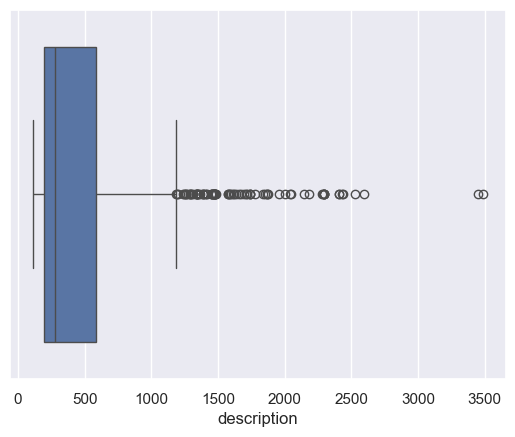

In [234]:
sns.boxplot(x=len_descriptions);

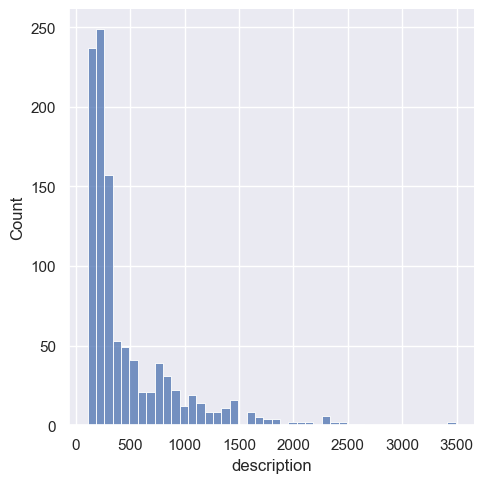

In [235]:
sns.displot(len_descriptions);

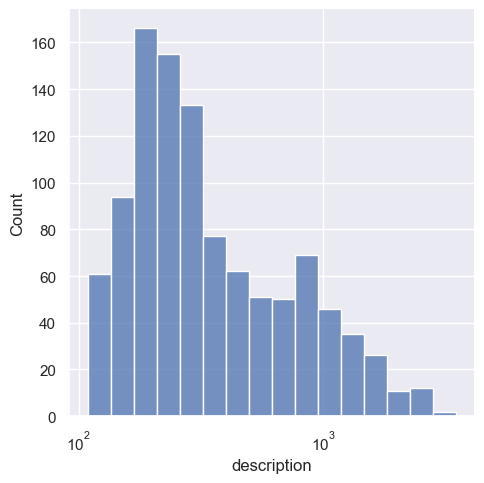

In [236]:
sns.displot(len_descriptions, log_scale=True);

## Exploration du corpus et des documents

### Affichage de n documents au hasard

In [237]:
df_text_samp = df_text.sample(10, random_state=0)
df_text_samp

product_name  \
743  Nutcase Sticker Wrap Design - Pineapple 800 ml...   
656                     BornBabyKids Cotton Bath Towel   
704  Home Originals Abstract, Abstract Double Blank...   
738              brass gift center Showpiece  -  48 cm   
496                              Sonata 7016YM04 Watch   
27           Disney DW100405 Digital Watch  - For Boys   
31    Lenco Bdblue Tango Analog Watch  - For Men, Boys   
553          Sonata 8974PP01 Analog Watch  - For Women   
682  VLCC Natural Sciences Oil Free Sunscreen Gel S...   
495                              Sonata 7007YL08 Watch   

                                           description  \
743  Nutcase Sticker Wrap Design - Pineapple 800 ml...   
656  Buy BornBabyKids Cotton Bath Towel at Rs. 589 ...   
704  Buy Home Originals Abstract, Abstract Double B...   
738  Key Features of brass gift center Showpiece  -...   
496  Sonata 7016YM04 Watch - Buy Sonata 7016YM04 Wa...   
27   Disney DW100405 Digital Watch  - For Boys - Bu...   
31   Lenco Bdblue Tango Analog Watch  - For Men, Bo...   
553  Sonata 8974PP01 Analog Watch  - For Women - Bu...   
682  Flipkart.com: Buy VLCC Natural Sciences Oil Fr...   
495  Sonata 7007YL08 Watch - Buy Sonata 7007YL08 Wa...   

                       category  
743            Kitchen & Dining  
656                   Baby Care  
704             Home Furnishing  
738  Home Decor & Festive Needs  
496                     Watches  
27                      Watches  
31                      Watches  
553                     Watches  
682    Beauty and Personal Care  
495                     Watches

In [238]:
# On affiche les 100 premiers caractères des description de l'échantillon
[val[:100] for val in df_text_samp['description'].values]

['Nutcase Sticker Wrap Design - Pineapple 800 ml Bottle (Pack of 1, Multicolor)\r\n                     ',
 'Buy BornBabyKids Cotton Bath Towel at Rs. 589 at Flipkart.com. Only Genuine Products. Free Shipping.',
 'Buy Home Originals Abstract, Abstract Double Blanket Multicolor at Rs. 1299 at Flipkart.com. Only Ge',
 'Key Features of brass gift center Showpiece  -  48 cm Brass Height - 48 cm Width - 12 cm Weight - 37',
 'Sonata 7016YM04 Watch - Buy Sonata 7016YM04 Watch  7016YM04 Online at Rs.789 in India Only at Flipka',
 'Disney DW100405 Digital Watch  - For Boys - Buy Disney DW100405 Digital Watch  - For Boys  DW100405 ',
 'Lenco Bdblue Tango Analog Watch  - For Men, Boys - Buy Lenco Bdblue Tango Analog Watch  - For Men, B',
 'Sonata 8974PP01 Analog Watch  - For Women - Buy Sonata 8974PP01 Analog Watch  - For Women  8974PP01 ',
 'Flipkart.com: Buy VLCC Natural Sciences Oil Free Sunscreen Gel SPF 15 (Pack of 2) - SPF 15 for Rs. 2',
 'Sonata 7007YL08 Watch - Buy Sonata 7007YL08 Watch  

In [239]:
df_text_samp['description'].iloc[1]

'Buy BornBabyKids Cotton Bath Towel at Rs. 589 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!'

# Text Processing

## Construction du corpus brut

In [243]:
# Les documents seront composés du nom du produit et de sa description
df_text['text'] = df_text['product_name'] + ' ' + df_text['description']
df_text.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description         category  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                                                text  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Specifications of S...  
2  Eurospa Cotton Terry Face Towel Set Key Featur...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

In [257]:
# Création du corpus
raw_corpus = ' '.join(df_text['text'].values)
raw_corpus[:1000]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

## Opérations de preprocessing

### Lower

In [258]:
corpus_lower = raw_corpus.lower().strip()
corpus_lower[:1000]

'elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant

In [259]:
len(corpus_lower)

546968

### Tokenization

In [271]:
tokens = word_tokenize(corpus_lower)
tokens[:10]

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'features',
 'of']

In [358]:
def display_tokens_info(tokens, n=20):
    """display info about the corpus and n tokens"""
    
    print(f'# tokens : {len(tokens)}\n# unique tokens : {len(set(tokens))}')
    if n > 0 :
        print("some tokens :", list(set(tokens))[:n], sep="\n")

In [283]:
display_tokens_info(tokens)

# tokens : 99490
# unique tokens : 6625
some tokens :
['285', 'delight', '1979', 'brahmz', 'bapa', 'carrier', 'only', 'soaps', '22000', '24', '4200', '40', 'macintosh', 'karahi', 'reserves', 'kitchen', 'surreal', 'asiacraft', 'traumatic', 'am']


### Stopwords

In [287]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [288]:
# On enlève les stopwords
tokens = [w for w in tokens if w not in stop_words]
display_tokens_info(tokens)

# tokens : 79896
# unique tokens : 6508
some tokens :
['285', 'delight', '1979', 'brahmz', 'bapa', 'carrier', 'soaps', '22000', '24', '4200', '40', 'macintosh', 'karahi', 'reserves', 'kitchen', 'surreal', 'asiacraft', 'traumatic', 'usage', 'broom']


### Ponctuation

In [290]:
tokens = [w for w in tokens if w not in string.punctuation]
display_tokens_info(tokens)

# tokens : 67184
# unique tokens : 6487
some tokens :
['285', 'delight', '1979', 'brahmz', 'bapa', 'carrier', 'soaps', '22000', '24', '4200', '40', 'macintosh', 'karahi', 'reserves', 'kitchen', 'surreal', 'asiacraft', 'traumatic', 'usage', 'broom']


### Liste des tokens rares

In [291]:
tokens_value_counts = pd.Series(tokens).value_counts()
tokens_value_counts[:10]

cm             652
products       632
free           617
rs             592
buy            582
replacement    568
delivery       567
genuine        564
cash           564
shipping       564
Name: count, dtype: int64

In [295]:
tokens_value_counts.describe()

count    6487.000000
mean       10.356713
std        38.855418
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       652.000000
Name: count, dtype: float64

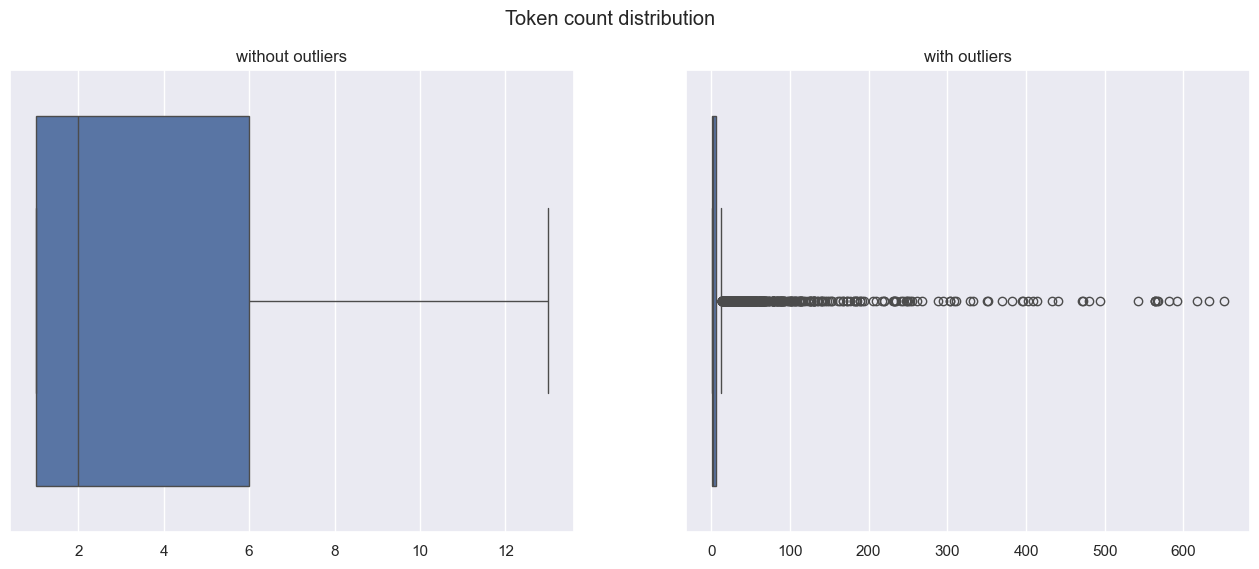

In [301]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.boxplot(x=tokens_value_counts.values, showfliers=False, ax=axs[0])
sns.boxplot(x=tokens_value_counts.values, showfliers=True, ax=axs[1])
fig.suptitle("Token count distribution")
axs[0].set_title("without outliers")
axs[1].set_title("with outliers")
plt.show()

In [306]:
unique_words = list(tokens_value_counts[tokens_value_counts == 1].index)
unique_words[:10]

['2nd',
 'instruments',
 'bollywood',
 'calnedars',
 'daily.',
 'stir-up',
 'thrillers',
 'buzz.',
 'vsswh001',
 'sole']

In [307]:
len(unique_words)

1871

On va enlever les mots qui n'apparaissent qu'une fois de notre liste de tokens

In [308]:
tokens = [w for w in tokens if w not in unique_words]
display_tokens_info(tokens)

# tokens : 65313
# unique tokens : 4616
some tokens :
['packing', 'dv4129ea', 'budding', 'groups', '285', 'delight', 'burt', '1979', 'girl', 'spandex', 'brahmz', 'b00', 'bapa', 'soaking', '7inch', 'sathiyas', '13.3', 'no./model', 'padded', 'royale']


### Mots courts

In [309]:
# On élimine les mots composés de moins de 'min_len_words' caractères
min_len_words = 3
tokens = [w for w in tokens if len(w) >= min_len_words]

In [310]:
display_tokens_info(tokens)

# tokens : 59717
# unique tokens : 4449
some tokens :
['packing', 'dv4129ea', 'budding', 'groups', '285', 'delight', 'burt', '1979', 'girl', 'spandex', 'brahmz', 'b00', 'bapa', 'soaking', '7inch', 'sathiyas', '13.3', 'no./model', 'padded', 'royale']


### Tokens alphabétiques

On enlève les tokens qui contiennent des chiffres

In [311]:
tokens = [w for w in tokens if w.isalpha()]
display_tokens_info(tokens)

# tokens : 55568
# unique tokens : 3584
some tokens :
['packing', 'budding', 'groups', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'soaking', 'sathiyas', 'padded', 'royale', 'carrier', 'soaps', 'purifies', 'compact', 'variant', 'printing', 'vibrations']


### Mots anglais seulement

In [315]:
eng_words = [w.lower() for w in words.words()] # tous les mots du dictionnaire anglais mis en minuscule
eng_words[:10]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron']

In [316]:
len(eng_words)

236736

In [317]:
len(set(eng_words))

234377

Voyons les mots de notre corpus qui ne font pas partie du dictionnaire

In [319]:
%%time
non_eng_tokens = [w for w in tokens if w not in eng_words]
display_tokens_info(non_eng_tokens)

# tokens : 12329
# unique tokens : 1260
some tokens :
['packing', 'groups', 'spandex', 'brahmz', 'bapa', 'sathiyas', 'padded', 'soaps', 'purifies', 'vibrations', 'reflexes', 'functions', 'oreal', 'lowest', 'eurospa', 'karahi', 'gifts', 'interiors', 'asiacraft', 'crstl']
CPU times: total: 1min 7s
Wall time: 1min 8s


On peut voir qu'il y a effectivement des mots qui ne font pas partie du dictionnaire mais certains mots sont anglais et n'ont pourtant pas été reconnus comme tel.
De plus, certains mots non-anglais peuvent tout de même être utiles car ils vont caractériser un certain type de produit, tel que le nom d'une marque par exemple.
Il vaut donc peut-être mieux garder ces mots.

### Lemmatisation

#### Exemples

Le processus de **lemmatisation** consiste à représenter les mots (ou « lemmes » ) sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier.

In [320]:
sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
sentence

'He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun.'

In [324]:
lemmatizer = WordNetLemmatizer()

sentence_tokens = nltk.word_tokenize(sentence)
print("{0:20}{1:20} \n".format("Word","Lemma") + '-'*30)
for word in sentence_tokens:
    print ("{0:20}{1:20}".format(word, lemmatizer.lemmatize(word)))

Word                Lemma                
------------------------------
He                  He                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
.                   .                   
He                  He                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
Sun                 Sun                 
.                   .    

#### Application

In [329]:
tokens_lem = [lemmatizer.lemmatize(w) for w in tokens]
display_tokens_info(tokens_lem)

# tokens : 55568
# unique tokens : 3306
some tokens :
['packing', 'sailor', 'budding', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'fight', 'soaking', 'sathiyas', 'padded', 'royale', 'carrier', 'component', 'purifies', 'compact', 'variant', 'printing']


### Stemming

#### Exemples

Il existe un autre processus qui exerce une fonction similaire qui s'appelle la racinisation(ou **stemming** en anglais). Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

In [330]:
sentence="Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success."
sentence

'Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success.'

In [331]:
stemmer = PorterStemmer()

sentence_tokens = nltk.word_tokenize(sentence)
print("{0:20}{1:20} \n".format("Word","Porter Stemmer") + '-'*35)
for word in sentence_tokens:
    print ("{0:20}{1:20}".format(word, stemmer.stem(word)))

Word                Porter Stemmer       
-----------------------------------
Pythoners           python              
are                 are                 
very                veri                
intelligent         intellig            
and                 and                 
work                work                
very                veri                
pythonly            pythonli            
and                 and                 
now                 now                 
they                they                
are                 are                 
pythoning           python              
their               their               
way                 way                 
to                  to                  
success             success             
.                   .                   


#### Application

In [332]:
tokens_stem = [stemmer.stem(w) for w in tokens]
display_tokens_info(tokens_stem)

# tokens : 55568
# unique tokens : 2958
some tokens :
['sailor', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'fight', 'peopl', 'blond', 'carrier', 'suav', 'compact', 'variant', 'fan', 'card', 'oreal', 'lowest', 'eurospa', 'karahi']


### WordCloud

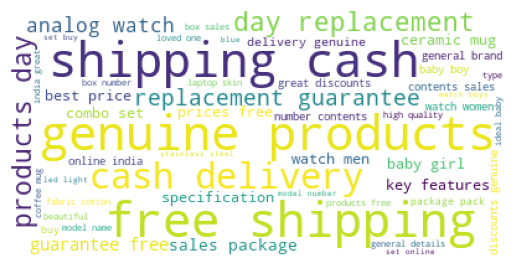

In [333]:
# Sans lemmatization ni stemming
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens))
plt.imshow(wordcloud)
plt.axis('off');

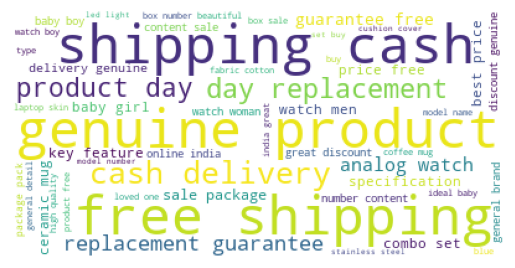

In [334]:
# Avec lemmatization
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens_lem))
plt.imshow(wordcloud)
plt.axis('off');

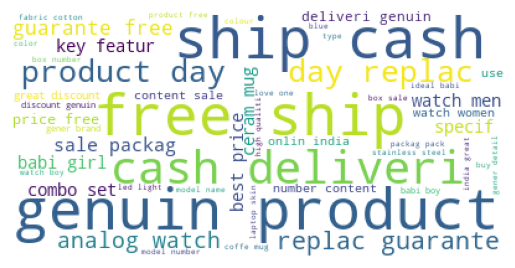

In [335]:
# Avec stemming
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens_stem))
plt.imshow(wordcloud)
plt.axis('off');

## **Fonction de text processing**

On va définir une fonction capable d'appliquer toutes les opérations vues précédemment

In [336]:
def process_text(doc, stop_words=None, list_rare_words=None, min_len_words=3, force_is_alpha=True,
                 extra_words=None, eng_words=None, lem_or_stem=None, rejoin=False):
    """
    Process a given document by applying various text processing steps.

    Parameters:
    -----------
    doc : str
        The document (a text in str format) to process.

    stop_words : list or None, optional
        List of stopwords to exclude from the document.

    list_rare_words : list or None, optional
        A list of rare words to exclude.

    min_len_words : int, optional
        The minimum length of words to include in the processed document.

    force_is_alpha : bool, optional
        If True, exclude all tokens that contain non-alphabetic characters.

    extra_words : list or None, optional
        List of extra words to exclude from the document.

    eng_words : list or None, optional
        List of English words to include in the processed document.

    lem_or_stem : str or None, optional
        If 'lem', lemmatizes the words; if 'stem', stems the words.

    rejoin : bool, optional
        If True, return the processed document as a single string; else return a list of tokens.

    Returns:
    --------
    list or str
        A list of tokens or a string if rejoin is True.
    """
    # Convert the document to lowercase and remove leading/trailing whitespaces
    doc = doc.lower().strip()

    # Tokenize the document
    tokens = word_tokenize(doc)

    ############################################################
    # Begin tokens processing
    ############################################################

    # Exclude classic stopwords if provided
    if stop_words:
        tokens = [w for w in tokens if w not in stop_words]

    # Exclude non-rare tokens if a list of rare words is provided
    if list_rare_words:
        tokens = [w for w in tokens if w not in list_rare_words]

    # Filter tokens based on minimum length requirement
    if min_len_words:
        tokens = [w for w in tokens if len(w) >= min_len_words]

    # Exclude tokens containing non-alphabetic characters if required
    if force_is_alpha:
        tokens = [w for w in tokens if w.isalpha()]

    # Drop extra words if provided
    if extra_words:
        tokens = [w for w in tokens if w not in extra_words]

    # Include only English words if a list is provided
    if eng_words:
        tokens = [w for w in tokens if w in eng_words]

    # Lemmatize or stem the tokens based on the specified method
    if lem_or_stem == 'lem':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    elif lem_or_stem == 'stem':
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(w) for w in tokens]

    ############################################################
    # End tokens processing
    ############################################################

    # Return the processed document as a single string if rejoin is True
    if rejoin:
        return ' '.join(tokens)

    # Return the list of tokens
    return tokens

Testons la fonction

In [338]:
test = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem=None,
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

test_lem = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem='lem',
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

test_stem = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem='stem',
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

print('Sans lemmatization ni stemming')
display_tokens_info(test)
print()
print('Avec lemmatization')
display_tokens_info(test_lem)
print()
print('Avec stemming')
display_tokens_info(test_stem)

Sans lemmatization ni stemming
# tokens : 55568
# unique tokens : 3584
some tokens :
['packing', 'budding', 'groups', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'soaking', 'sathiyas', 'padded', 'royale', 'carrier', 'soaps', 'purifies', 'compact', 'variant', 'printing', 'vibrations']

Avec lemmatization
# tokens : 55568
# unique tokens : 3306
some tokens :
['packing', 'sailor', 'budding', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'fight', 'soaking', 'sathiyas', 'padded', 'royale', 'carrier', 'component', 'purifies', 'compact', 'variant', 'printing']

Avec stemming
# tokens : 55568
# unique tokens : 2958
some tokens :
['sailor', 'delight', 'burt', 'girl', 'spandex', 'brahmz', 'bapa', 'fight', 'peopl', 'blond', 'carrier', 'suav', 'compact', 'variant', 'fan', 'card', 'oreal', 'lowest', 'eurospa', 'karahi']


On obtient bien les mêmes résultats que précédemment

## Extra words

On va supprimer les mots qui apparaissent souvent dans toutes les catégorie car ils ne serviront pas à les différencier.

### Séparation des catégories

In [339]:
for cat in df_text['category'].unique():
    print(cat)

Home Furnishing
Baby Care
Watches
Home Decor & Festive Needs
Kitchen & Dining
Beauty and Personal Care
Computers


In [340]:
# On crée un dictionnaire comportant le corpus de chaque catégorie
corpus_dic = {}
for cat in df_text['category'].unique():
    corpus = df_text.loc[df_text['category'] == cat, 'text']
    corpus_dic[cat] = ' '.join(corpus)

In [356]:
print("{0:30}{1:30} \n".format("Category", "Corpus length") + '='*45)
for key in corpus_dic.keys():
    print ("{0:30}{1:10}".format(key, len(corpus_dic[key])))
    print("-"*45)

Category                      Corpus length                  
Home Furnishing                    63622
---------------------------------------------
Baby Care                          78679
---------------------------------------------
Watches                            56213
---------------------------------------------
Home Decor & Festive Needs         92595
---------------------------------------------
Kitchen & Dining                  101184
---------------------------------------------
Beauty and Personal Care           63840
---------------------------------------------
Computers                          90829
---------------------------------------------


### Processing

In [357]:
# On tokenize les corpus de chaque catégorie et on met les résultats dans un dictionnaire
tokens_dic = {}
for cat in df_text['category'].unique():
    tokens_dic[cat] = process_text(corpus_dic[cat],
                            stop_words=stop_words,
                            #list_rare_words=unique_words,
                            min_len_words=3,
                            force_is_alpha=True,
                            #lem_or_stem='stem',
                            eng_words=None,
                            extra_words=None,
                            rejoin=False,
                           )

In [359]:
for key in tokens_dic.keys():
    print(key)
    display_tokens_info(tokens_dic[key], n=0)
    print()

Home Furnishing
# tokens : 6786
# unique tokens : 850

Baby Care
# tokens : 9141
# unique tokens : 1237

Watches
# tokens : 5477
# unique tokens : 443

Home Decor & Festive Needs
# tokens : 9332
# unique tokens : 1575

Kitchen & Dining
# tokens : 10089
# unique tokens : 1201

Beauty and Personal Care
# tokens : 6733
# unique tokens : 1212

Computers
# tokens : 9091
# unique tokens : 1055



### Extra words

On va lister les mots qui apparaissent dans le top n des mots les plus cités de chaque catégorie et qui sont communs à toutes les catégories

In [360]:
n = 100
# Mots du top 'n' de la carégorie 'Home Furnishing'
common_words = pd.Series(tokens_dic['Home Furnishing']).value_counts().head(n).index
pd.Series(tokens_dic['Home Furnishing']).value_counts().head(n)

cotton            138
cover             104
single             91
pack               89
polyester          82
                 ... 
furnishingland     18
additional         17
rajasthan          17
covers             17
product            17
Name: count, Length: 100, dtype: int64

In [361]:
for cat in tokens_dic.keys():
    if cat == 'Home Furnishing':
        continue
    # Mots du top 'n' de la carégorie 'cat'
    top_words = pd.Series(tokens_dic[cat]).value_counts().head(n).index
    common_words = [w for w in common_words if w in top_words]

In [362]:
len(common_words)

15

In [363]:
# Mots apparaissant dans le top 100 de toutes les catégories
common_words

['buy',
 'free',
 'products',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'color',
 'features',
 'price',
 'brand',
 'specifications',
 'box',
 'general',
 'type']

## Processing final

In [365]:
df_text = df_text[['category', 'text']]
df_text.head()

category                                               text
0  Home Furnishing  Elegance Polyester Multicolor Abstract Eyelet ...
1        Baby Care  Sathiyas Cotton Bath Towel Specifications of S...
2        Baby Care  Eurospa Cotton Terry Face Towel Set Key Featur...
3  Home Furnishing  SANTOSH ROYAL FASHION Cotton Printed King size...
4  Home Furnishing  Jaipur Print Cotton Floral King sized Double B...

In [366]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_text(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              #lem_or_stem='stem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_text_lem(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              lem_or_stem='lem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc

# Fonction de préparation du texte pour le bag of words avec stemming
def transform_text_stem(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              lem_or_stem='stem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc


df_text['clean_text'] = df_text['text'].apply(transform_text)
df_text['clean_text_lem'] = df_text['text'].apply(transform_text_lem)
df_text['clean_text_stem'] = df_text['text'].apply(transform_text_stem)

CPU times: total: 5.31 s
Wall time: 5.39 s


In [367]:
df_text.head()

category                                               text  \
0  Home Furnishing  Elegance Polyester Multicolor Abstract Eyelet ...   
1        Baby Care  Sathiyas Cotton Bath Towel Specifications of S...   
2        Baby Care  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  Home Furnishing  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Home Furnishing  Jaipur Print Cotton Floral King sized Double B...   

                                          clean_text  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set key eurosp...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                      clean_text_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set key eurosp...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                     clean_text_stem  
0  eleg polyest multicolor abstract eyelet door c...  
1  sathiya cotton bath towel sathiya cotton bath ...  
2  eurospa cotton terri face towel set key eurosp...  
3  santosh royal fashion cotton print king size d...  
4  jaipur print cotton floral king size doubl bed...

In [368]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         1050 non-null   object
 1   text             1050 non-null   object
 2   clean_text       1050 non-null   object
 3   clean_text_lem   1050 non-null   object
 4   clean_text_stem  1050 non-null   object
dtypes: object(5)
memory usage: 41.1+ KB


In [372]:
# On enregistre le DataFrame au format csv
df_text.to_csv('data/df_text.csv')

# Fonctions pour l'analyse

In [23]:
import os
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

from sklearn import manifold, cluster, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D

from transformers import *

from nltk.tokenize import word_tokenize
import gensim

c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [2]:
df_text = pd.read_csv('data/df_text.csv', index_col=0)
print(df_text.shape)
df_text.head()

(1050, 5)


text         category  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  Home Furnishing   
1  Sathiyas Cotton Bath Towel Specifications of S...        Baby Care   
2  Eurospa Cotton Terry Face Towel Set Key Featur...        Baby Care   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  Home Furnishing   
4  Jaipur Print Cotton Floral King sized Double B...  Home Furnishing   

                                          clean_text  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set key eurosp...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                      clean_text_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set key eurosp...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                     clean_text_stem  
0  eleg polyest multicolor abstract eyelet door c...  
1  sathiya cotton bath towel sathiya cotton bath ...  
2  eurospa cotton terri face towel set key eurosp...  
3  santosh royal fashion cotton print king size d...  
4  jaipur print cotton floral king size doubl bed...

In [24]:
def ARI_fct(data, n_labels, cat_labels):
    """
    Function to determine t-SNE, determine clusters and compute ARI between clusters and real categories.
    
    Positional arguments :
    ----------------------
    
    encoded_data : nd_array
        text data encoded into a ndarray
    
    n_labels : int
        number of categories
        
    cat_labels : 1darray or list
        real category labels for each point
        
    return
    ------
    
    ARI : float
        ARI score
    
    X_tsne : 2darray
        embedding of the training data in 2-dimensional space
        
    cls.labels_ : ndarray
        cluster labels of each point
    """
    start = time.time()
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(data)
    
    # Détermination des clusters à partir des données après t-SNE 
    cls = cluster.KMeans(n_clusters=n_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(cat_labels, cls.labels_), 2)
    end = time.time()
    print("ARI : ", ARI, "duration : ", np.round(end - start, 1), 's')
    
    return ARI, X_tsne, cls.labels_


def TSNE_visu_fct(X_tsne, cat_labels, cluster_labels, categories, ARI, xlim=None, ylim=None, legend_loc='best',
                  show_ticks=False, legend=True):
    """
    Function to visualize TSNE by real categories and clusters.
    
    Positional arguments :
    ----------------------
    
    X_tsne : 2darray
        embedding of the data in 2-dimensional space
        
    cat_labels : 1darray or list
        real category labels
        
    cluster_labels : 1darray or list
        cluster labels
        
    categories : list
        list of categories
        
    ARI : float
        ARI score between real categories and clusters
        
    optional arguments :
    --------------------
    
    xlim, ylim : tuples of floats
        limits of the x- and y-axis
        
    legend_loc : str or pair of floats, default='best'
        The location of the legend.
        
    show_ticks : bool, default=False
        whether to show ticks or not.

    legend : bool, default=True
        whether to show legends or not.
    """
    fig = plt.figure(figsize=(15,6))
    
    # Plot TSNE data labeled by real categories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=cat_labels, cmap='Set1')
    if legend:
        ax.legend(handles=scatter.legend_elements()[0], labels=categories, loc=legend_loc, title="Categories")
    ax.set_title('Représentation par catégories réelles', fontsize=20, fontweight='bold', pad=15)
    ax.set_xlabel('X_tsne1', fontsize=16, fontweight='normal')
    ax.set_ylabel('X_tsne2', fontsize=16, fontweight='normal')

    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if show_ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Plot TSNE data labeled by clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=cluster_labels, cmap='Set1')

    cls_labels = [f'Cluster {i}' for i in set(cluster_labels)]
    if legend:
        ax.legend(handles=scatter.legend_elements()[0], labels=cls_labels, loc=legend_loc, title="Clusters")
    ax.set_title('Représentation par clusters', fontsize = 20, fontweight = 'bold', pad=15)
    ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
    ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
    
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if show_ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    print("ARI : ", ARI)

def switch(cluster_labels, i, j):
    """Function that switches cluster labels"""
    store = 2*(i+j) + 5
    cluster_labels[cluster_labels == i] = store
    cluster_labels[cluster_labels == j] = i
    cluster_labels[cluster_labels == store] = j

# Bag of words

## Comtage simple

In [9]:
# Paramètres
text = 'clean_text_lem' # colonne utilisée pour le bag of words
categories = list(df_text['category'].unique()) # liste des catégories
n_labels = len(categories)
# étiquetage des points selon leur catégorie
cat_labels = df_text['category'].apply(lambda x: categories.index(x)).values

In [16]:
# création du bag of words
cvect = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
X_bow = cvect.fit_transform(df_text[text])

# Réduction de dimensionnalité
pca = PCA(n_components=0.99, random_state=0)
print('Dimensions du dataset avant réduction PCA :', X_bow.shape)
X_bow_pca = pca.fit_transform(X_bow.toarray())
print('Dimensions du dataset après réduction PCA : ', X_bow_pca.shape)
print('Pourcentage de la variance expliquée : %.1f'%(100*pca.explained_variance_ratio_.sum()))
print()

# TSNE et clustering
print()
print("t-SNE et clustering")
print("-----------------")
print('Données non-réduites :')
ARI_bow, X_bow_tsne, labels_bow = ARI_fct(X_bow, n_labels, cat_labels)
print('Données réduites :')
ARI_bow_pca, X_bow_pca_tsne, labels_bow_pca = ARI_fct(X_bow_pca, n_labels, cat_labels)

Dimensions du dataset avant réduction PCA : (1050, 3206)
Dimensions du dataset après réduction PCA :  (1050, 634)
Pourcentage de la variance expliquée : 99.0


t-SNE et clustering
-----------------
Données non-réduites :
ARI :  0.44 duration :  7.4 s
Données réduites :
ARI :  0.47 duration :  8.0 s


En appliquant une ACP à 99% de variance expliquée sur les données avant d'effectuer la réduction de dimension t-SNE, on obtient un meilleur ARI et en un temps plus court.

## Visualisation

In [17]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bow_pca, 0, 5)
switch(labels_bow_pca, 1, 3)
switch(labels_bow_pca, 4, 5)
switch(labels_bow_pca, 5, 6)

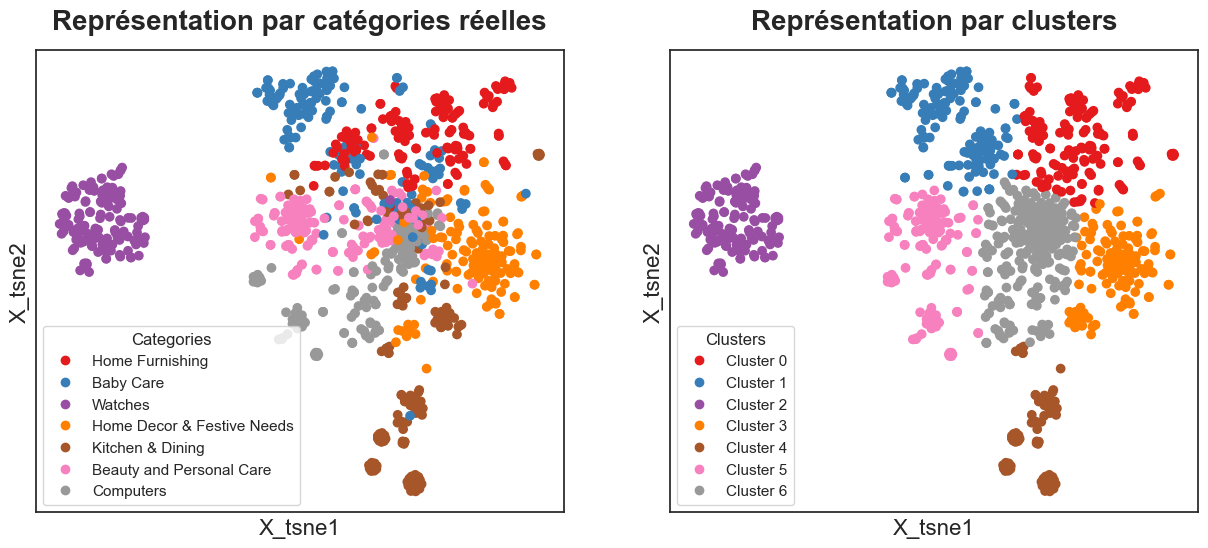

ARI :  0.47


In [18]:
 TSNE_visu_fct(X_bow_pca_tsne, cat_labels, labels_bow_pca, categories, ARI_bow_pca)

## TF-IDF

In [37]:
# création du bag of words
ctf = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english')
X_tfidf = ctf.fit_transform(df_text[text])

# Réduction de dimensionnalité
pca = PCA(n_components=0.99, random_state=0)
print('Dimensions dataset avant réduction PCA :', X_tfidf.shape)
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())
print('Dimensions dataset après réduction PCA : ', X_tfidf_pca.shape)
print('Pourcentage de la variance expliquée : %.1f'%(100*pca.explained_variance_ratio_.sum()))
print()

# TSNE et clustering
print("t-SNE et clustering ")
print("--------")
print('Données non-réduites :')
ARI_tfidf, X_tfidf_tsne, labels_tfidf = ARI_fct(X_tfidf, n_labels, cat_labels)
print('Données réduites :')
ARI_tfidf_pca, X_tfidf_pca_tsne, labels_tfidf_pca = ARI_fct(X_tfidf_pca, n_labels, cat_labels)

Dimensions dataset avant réduction PCA : (1050, 3206)
Dimensions dataset après réduction PCA :  (1050, 773)
Pourcentage de la variance expliquée : 99.0

t-SNE et clustering 
--------
Données non-réduites :
ARI :  0.57 duration :  5.6 s
Données réduites :
ARI :  0.5 duration :  7.3 s


Cette fois, les résultats sont moins bons lorsqu'on réduit les dimensions avec une ACP.

In [38]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_tfidf, 0, 4)
switch(labels_tfidf, 1, 4)
switch(labels_tfidf, 2, 3)
switch(labels_tfidf, 3, 6)
switch(labels_tfidf, 4, 5)
switch(labels_tfidf, 5, 6)

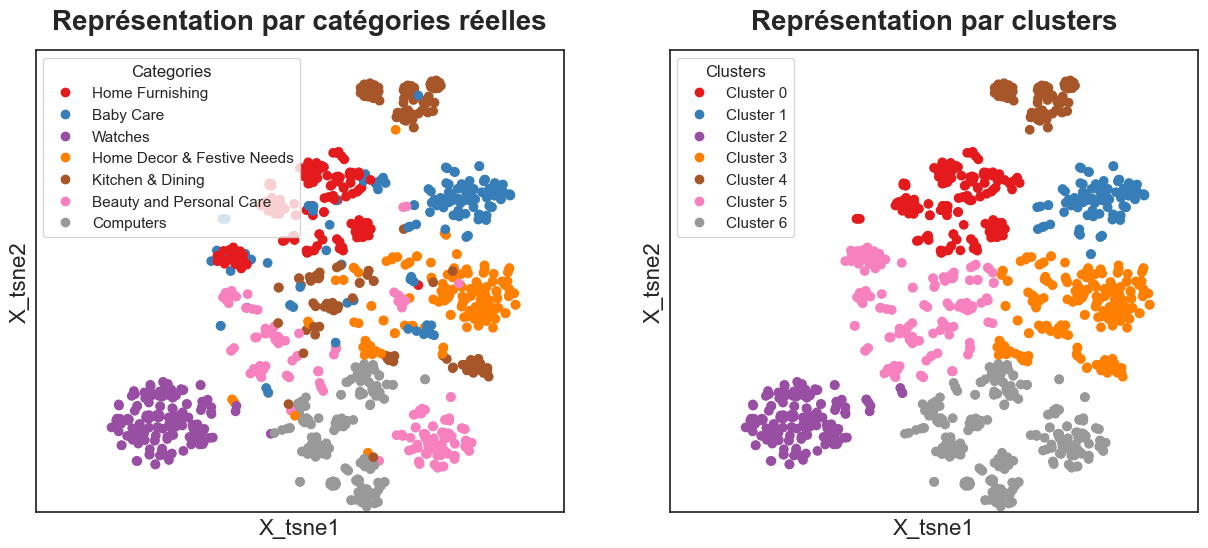

ARI :  0.57


In [39]:
 TSNE_visu_fct(X_tfidf_tsne, cat_labels, labels_tfidf, categories, ARI_tfidf, 
               xlim=(-70, 50), ylim=(-60, 80)
              )

## Classification

On va entraîné un modèle de classification standard pour voir si on obtient des résultats satisfaisants avec le preprocessing qu'on a effectué. On va utiliser ici un modèle de régression logistique.

In [40]:
# Pour le comptage simple
X_train, X_test, y_train, y_test = train_test_split(X_bow, cat_labels, test_size=0.2, random_state=2024)
print(f'X_train shape : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shape : {X_test.shape}, y_test shape : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train shape : (840, 3206), y_train shape : (840,)
X_test shape : (210, 3206), y_test shape : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.994
Accuracy on validation set : 0.924


In [41]:
# Pour le TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, cat_labels, test_size=0.2, random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 3206), y_train : (840,)
X_test : (210, 3206), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.936
Accuracy on validation set : 0.857


On peut voir que les résultats sont très bons, en particulier pour le comptage simple, le tout avec un modèle simple et sans optimisation des hyper-pramaètres.

# Word2Vec

On regarde le nombre de tokens par documents pour voir à peu près quelle valeur choisir pour le paramètre `max_len` du modèle de Word2Vec.

count    1050.000000
mean       46.574286
std        43.872559
min         3.000000
25%        17.000000
50%        29.000000
75%        64.000000
max       299.000000
Name: clean_text, dtype: float64


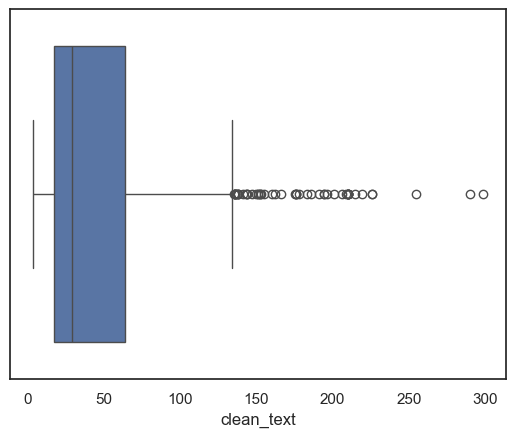

In [10]:
text = 'clean_text'
num_tokens = df_text[text].apply(word_tokenize)
num_tokens = num_tokens.apply(lambda x: len(x))
print(num_tokens.describe())

sns.boxplot(x=num_tokens)
plt.show()

## Analyse

In [14]:
def word2vec_evaluation(documents, max_len, preprocess=False, w2v_size=300,
                        window=5, min_count=1, epochs=100):
    """
    Evaluation function for the Word2Vec model
    """

    # tokenization des documents
    if preprocess == True:
        documents = [gensim.utils.simple_preprocess(text) for text in documents]
    else:
        documents = [doc.split(' ') for doc in documents]

    # Création et entraînement du modèle Word2Vec
    start = time.time()
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=min_count,
                                       window=window,
                                       vector_size=w2v_size,
                                       seed=42,
                                       workers=1,
                                       #workers=multiprocessing.cpu_count()
                                      )    
    w2v_model.build_vocab(documents)
    w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=epochs)
    end = time.time()
    print("Word2Vec trained")
    print('Duration : %.2f s'%(end-start))
    
    # Récupération des vecteurs
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key # Vocabulaire du corpus
    print(f"Vocabulary size: {len(w2v_words)}")
    print()
    
    # Transformation des tokens en séquences
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)

    num_words = len(tokenizer.word_index)
    print("Number of unique words: %i"%num_words)
    print()

    # Padding des documents
    x_documents = pad_sequences(tokenizer.texts_to_sequences(documents),
                                maxlen=max_len, # longueur maximale des sequences
                                padding='post'
                               ) 
    
    # Création de la matrice d'embedding
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0    
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            # vectorisation du mot
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i, 4)
    print(f"Word embedding rate : {word_rate}")
    print(f"Embedding matrix shape : {embedding_matrix.shape}")
    print()

    # Création du modèle d'embedding
    print("Create Embedding model ...")
    #x_input = Input(shape=(len(x_documents), max_len), dtype='float64')
    word_input = Input(shape=(max_len,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights = [embedding_matrix],
                               input_length=max_len)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    embed_model.summary()
    print()

    # Exécution du modèle
    print('Execution of the model...')
    X_emb = embed_model.predict(x_documents)
    print()

    return X_emb

documents = df_text[text].to_list()
X_emb = word2vec_evaluation(documents, max_len=150)

Build & train Word2Vec model ...
Word2Vec trained
Duration : 6.82 s
Vocabulary size: 3569

Fit Tokenizer ...
Number of unique words: 3569

Create Embedding matrix ...
Word embedding rate : 1.0
Embedding matrix shape : (3570, 300)

Create Embedding model ...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 300)          1071000   
                                                                 
 global_average_pooling1d_2  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1071000 (4.09 MB)
Trainable params: 1071000 (4.09 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [38]:
# t-SNE et clustering
ARI_emb, X_emb_tsne, labels_emb = ARI_fct(X_emb, n_labels, cat_labels)

ARI :  0.58 duration :  6.0 s


## Visualisation

In [39]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_emb, 0, 2)
switch(labels_emb, 1, 5)
switch(labels_emb, 2, 5)
switch(labels_emb, 4, 5)
switch(labels_emb, 5, 6)

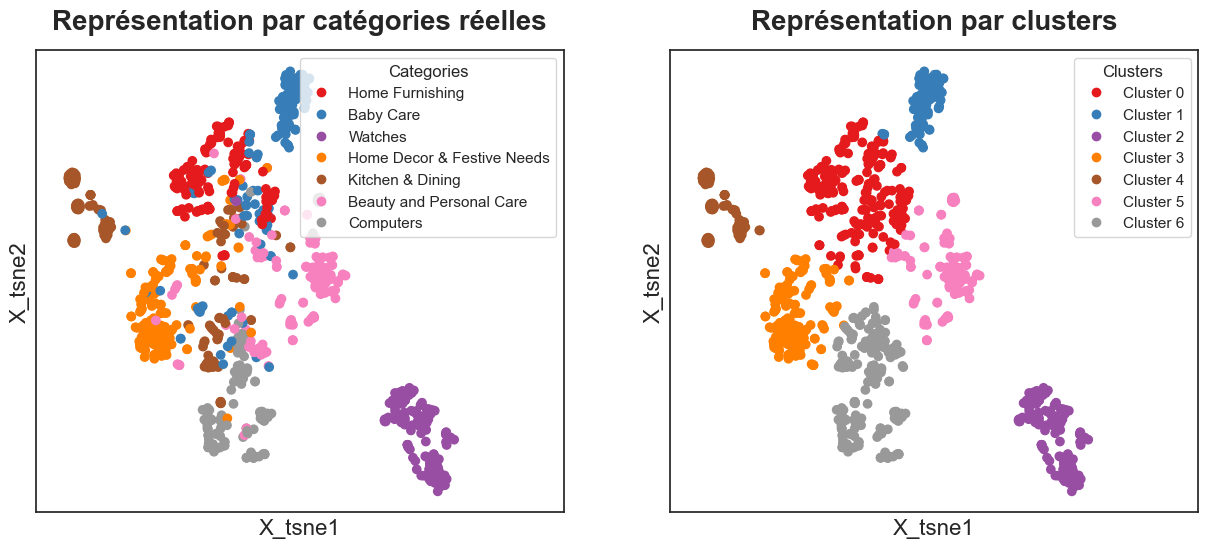

ARI :  0.58


In [40]:
TSNE_visu_fct(X_emb_tsne, cat_labels, labels_emb, categories, ARI_emb,
              xlim=(-60, 90),
              # show_ticks=True
             )

## Classification

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_emb, cat_labels, test_size=0.2, random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 300), y_train : (840,)
X_test : (210, 300), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.893
Accuracy on validation set : 0.843


Les résultats sont moins bon qu'avec le comptage simple.

## Comparaison avec les data non nettoyées

count    1050.000000
mean       94.800952
std        84.951965
min        23.000000
25%        42.000000
50%        60.500000
75%       113.750000
max       644.000000
Name: text, dtype: float64


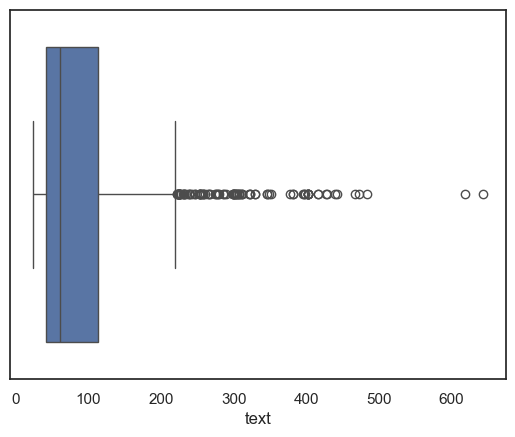

In [42]:
text = 'text'
len_text = df_text[text].apply(word_tokenize)
len_text = len_text.apply(lambda x: len(x))
print(len_text.describe())

sns.boxplot(x=len_text)
plt.show()

In [48]:
#text = 'text'
documents = df_text[text].to_list()
X_emb = word2vec_evaluation(documents, max_len=300, preprocess=True) # this time preprocess=True
ARI_emb, X_emb_tsne, labels_emb = ARI_fct(X_emb, n_labels, cat_labels)

Build & train Word2Vec model ...
Word2Vec trained
Duration : 12.35 s
Vocabulary size: 5192

Fit Tokenizer ...
Number of unique words: 5192

Create Embedding matrix ...
Word embedding rate : 1.0
Embedding matrix shape : (5193, 300)

Create Embedding model ...
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 300, 300)          1557900   
                                                                 
 global_average_pooling1d_6  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1557900 (5.94 MB)
Trainable params: 1557900 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________

On voit que l'ARI est beaucoup moins bon : on passe de 0.59 à 0.31

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_emb, cat_labels, test_size=0.2, random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 300), y_train : (840,)
X_test : (210, 300), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.856
Accuracy on validation set : 0.824


# BERT

In [112]:
# import logging
# logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# os.environ["TF_KERAS"] = '1'

In [56]:
print('tf version :', tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf version : 2.15.0
Num GPUs Available:  0


## Fonctions communes

In [57]:
from tqdm import tqdm

# Fonction de préparation des documents
def bert_inp_fct(documents, bert_tokenizer, max_length):
    """
    Function that returns the inputs for BERT model
    """
    input_ids = []
    token_type_ids = []
    attention_mask = []

    for doc in documents:
        bert_inp = bert_tokenizer.encode_plus(doc,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.asarray(attention_mask)
    
    return input_ids, token_type_ids, attention_mask
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, documents, max_length, batch_size, mode='HF'):
    # Calcul du nombre de batches
    quotient = len(documents)//batch_size
    remainder = len(documents)%batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1
    
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    start = time.time()
    for step in tqdm(range(n_batches)):
        idx = step * batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder

        input_ids, token_type_ids, attention_mask = bert_inp_fct(documents[idx:idx+b_size], 
                                                                 bert_tokenizer, max_length)
        
        if mode == 'HF' :    # Bert from HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=b_size,
                                    verbose=0)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub' : # Bert from Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    end = time.time()
    print("Duration : ", np.round(end-start, 0), 's')

    return features_bert, last_hidden_states_tot

## BERT from HuggingFace

In [58]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
documents = df_text['text'].to_list()

# Création des features
features_bert_hf, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents,
                                                            max_length, batch_size, mode='HF')

config.json: 100%|██████████| 570/570 [00:00<?, ?B/s] 
c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
loading

Duration :  97.0 s


In [80]:
ARI_bert_hf, X_bert_hf_tsne, labels_bert_hf = ARI_fct(features_bert_hf, n_labels, cat_labels)

ARI :  0.4 duration :  6.4 s


In [81]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_hf, 0, 5)
switch(labels_bert_hf, 1, 5)
switch(labels_bert_hf, 2, 3)
switch(labels_bert_hf, 3, 4)
switch(labels_bert_hf, 4, 6)
switch(labels_bert_hf, 5, 6)

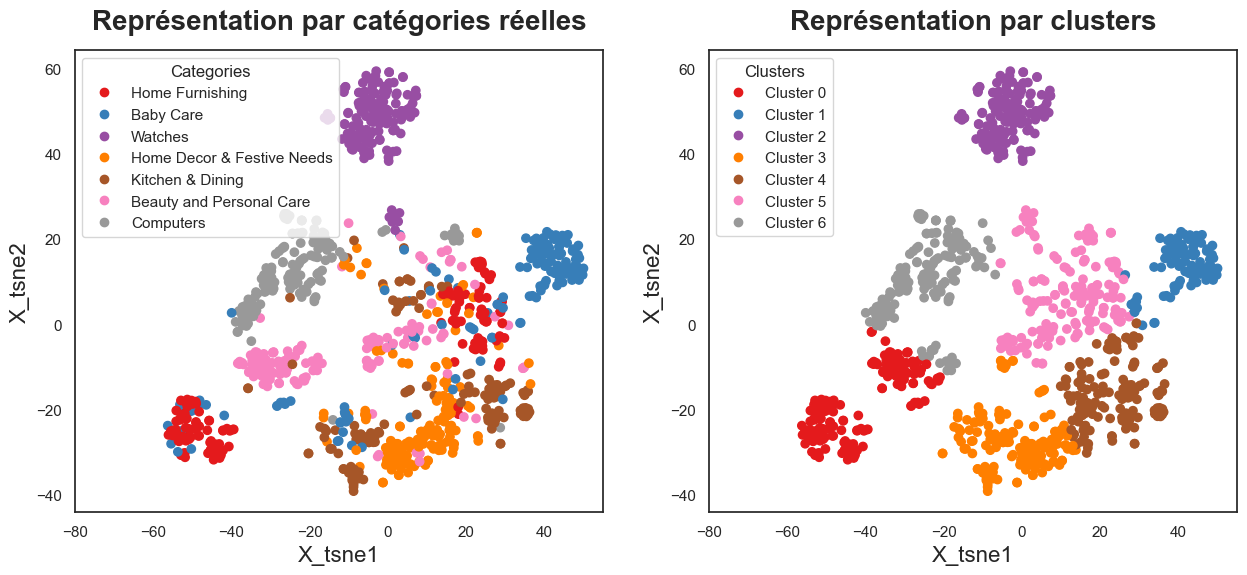

ARI :  0.4


In [82]:
TSNE_visu_fct(X_bert_hf_tsne, cat_labels, labels_bert_hf, categories, ARI_bert_hf,
              legend_loc="upper left",
              xlim=(-80, 55),
            #   ylim=(-45, 70),
              show_ticks=True
             )

## Classification

In [83]:
X_train, X_test, y_train, y_test = train_test_split(features_bert_hf, cat_labels, test_size=0.2, 
                                                    random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)



Results of the Logistic Regression :
Accuracy on training set : 0.961
Accuracy on validation set : 0.914


## BERT from Tensorflow Hub

In [85]:
import tensorflow_hub as hub

model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [86]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
documents = df_text['text'].to_list()

features_bert_tfh, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2

Duration :  99.0 s


In [102]:
ARI_bert_tfh, X_bert_tfh_tsne, labels_bert_tfh = ARI_fct(features_bert_tfh, n_labels, cat_labels)

ARI :  0.43 duration :  6.2 s


In [103]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_tfh, 0, 2)
switch(labels_bert_tfh, 1, 4)
switch(labels_bert_tfh, 2, 3)
switch(labels_bert_tfh, 3, 6)
switch(labels_bert_tfh, 4, 6)

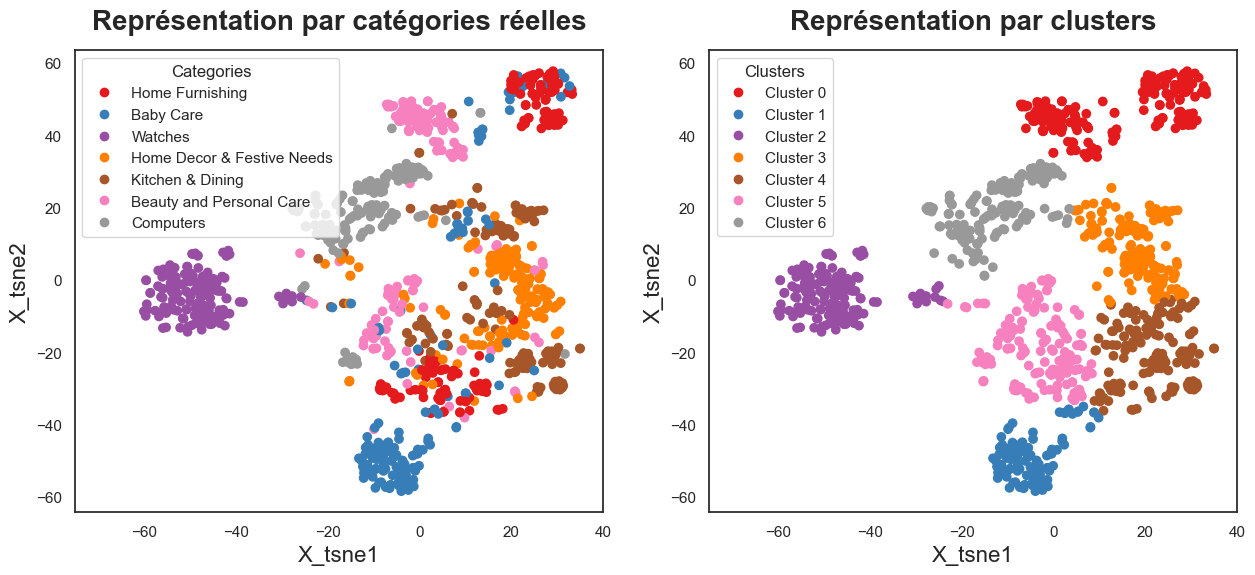

ARI :  0.43


In [104]:
TSNE_visu_fct(X_bert_tfh_tsne, cat_labels, labels_bert_tfh, categories, ARI_bert_tfh,
              xlim=(-75, 40),
            #   ylim=(-75,65),
              legend_loc='upper left',
              show_ticks=True
              )

## Classification

In [105]:
X_train, X_test, y_train, y_test = train_test_split(features_bert_tfh, cat_labels, test_size=0.2, 
                                                    random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)



Results of the Logistic Regression :
Accuracy on training set : 0.961
Accuracy on validation set : 0.914


# USE - Universal Sentence Encoder

## Analyse

In [106]:
# Cette commande peut prendre plusieurs minutes à s'exécuter la première fois
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [107]:
def feature_USE_fct(documents, batch_size) :
    quotient = len(documents)//batch_size
    remainder = len(documents)%batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1
    
    start = time.time()
    for step in range(n_batches):
        idx = step * batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder
            
        feat = embed(documents[idx:idx+b_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    end = time.time()
    print("duration : ", np.round(end-start, 0), 's')
    return features

In [108]:
batch_size = 10
documents = df_text['text'].to_list()

In [109]:
X_use = feature_USE_fct(documents, batch_size)

duration :  1.0 s


This model is much faster than the BERT model we used before.

In [120]:
ARI_use, X_use_tsne, labels_use = ARI_fct(X_use, n_labels, cat_labels)

ARI :  0.52 duration :  7.4 s


In [121]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_use, 0, 4)
switch(labels_use, 1, 4)
switch(labels_use, 3, 5)
switch(labels_use, 4, 5)

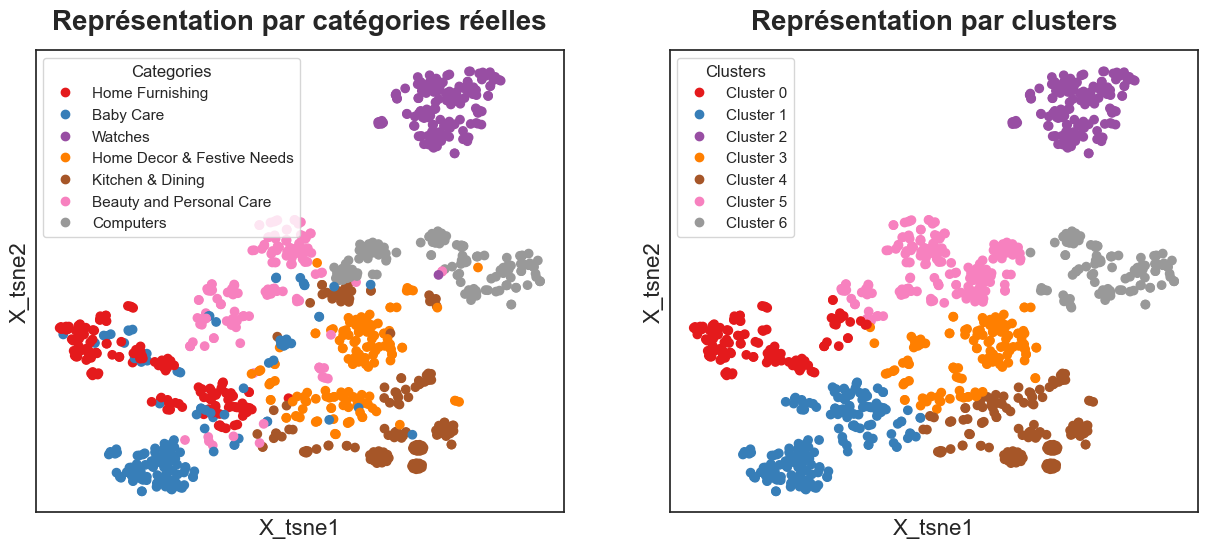

ARI :  0.52


In [122]:
TSNE_visu_fct(X_use_tsne, cat_labels, labels_use, categories, ARI_use,
            #   xlim=(-75,40), legend_loc='upper left'
             )

## Classification

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_use, cat_labels, test_size=0.2, 
                                                    random_state=2024)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 512), y_train : (840,)
X_test : (210, 512), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.907
Accuracy on validation set : 0.862


# Traitement des images avec SIFT

In [1]:
import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
sns.set_theme(style='white')

from sklearn import manifold, cluster, metrics
from sklearn.decomposition import PCA

import cv2

In [2]:
def imshow(image, cmap="gray"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

## Préparation des données

### Création du dataset

In [3]:
# import des données
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df_text = pd.read_csv('data/df_text.csv', index_col=0)

categories = list(df_text['category'].unique()) # liste des catégories
n_labels = len(categories) # nombre de catégories

# encodage des catégories
cat_labels = df_text['category'].apply(lambda x: categories.index(x)).values

# création du DataFrame pour traiter les images
df_images = pd.DataFrame({'image_path': df["image"].map(lambda x: f"./data/images/{x}"),
                          'category': df_text['category'],
                          'label': cat_labels})
df_images.to_csv('data/df_images.csv')
df_images.head()

image_path         category  label
0  ./data/images/55b85ea15a1536d46b7190ad6fff8ce7...  Home Furnishing      0
1  ./data/images/7b72c92c2f6c40268628ec5f14c6d590...        Baby Care      1
2  ./data/images/64d5d4a258243731dc7bbb1eef49ad74...        Baby Care      1
3  ./data/images/d4684dcdc759dd9cdf41504698d737d8...  Home Furnishing      0
4  ./data/images/6325b6870c54cd47be6ebfbffa620ec7...  Home Furnishing      0

### Affichage d'exemples d'images

                           Home Furnishing                            


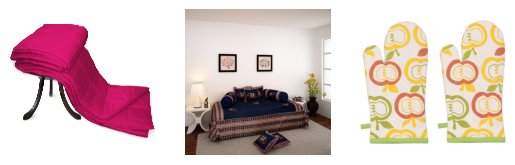

                              Baby Care                               


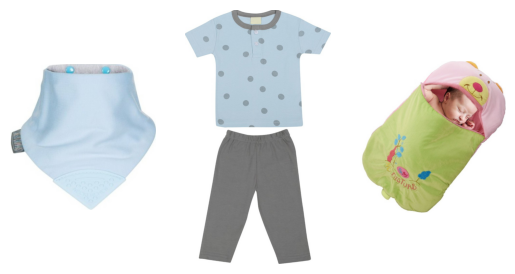

                               Watches                                


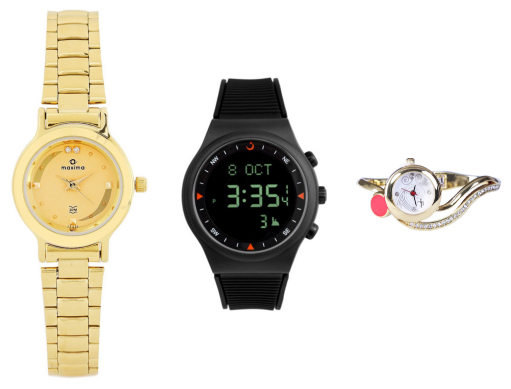

                      Home Decor & Festive Needs                      


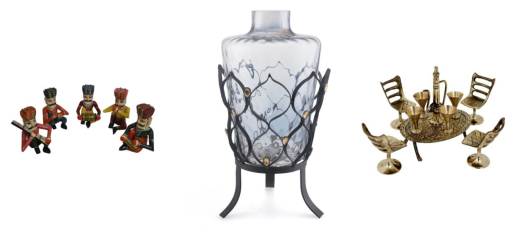

                           Kitchen & Dining                           


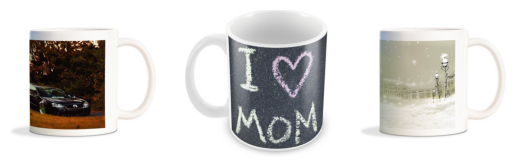

                       Beauty and Personal Care                       


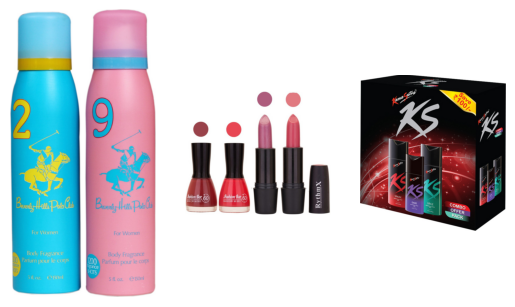

                              Computers                               


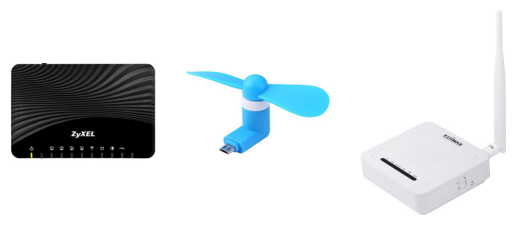

In [4]:
# On va afficher 3 images par catégories
for cat in categories:
    print(cat.center(70))
    paths = list(df_images.loc[df_images['category']==cat, 'image_path'].sample(3, random_state=3))
    for i in range(3):
        plt.subplot(130 + 1 + i)
        image = imread(paths[i])
        imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

### Exemple sur une image

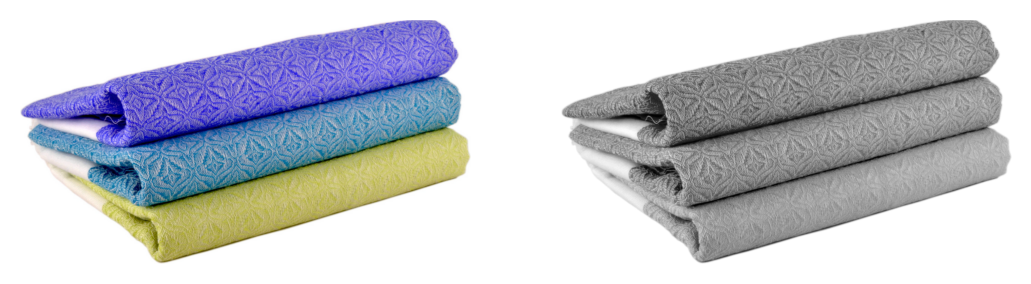

In [5]:
image = cv2.imread(df_images['image_path'].iloc[1], 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(dpi=200)
plt.subplot(121)
imshow(image)
plt.subplot(122)
imshow(gray)

In [6]:
# convert back to rgb-scale for upcoming plots
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
gray_rgb.shape

(1293, 2388, 3)

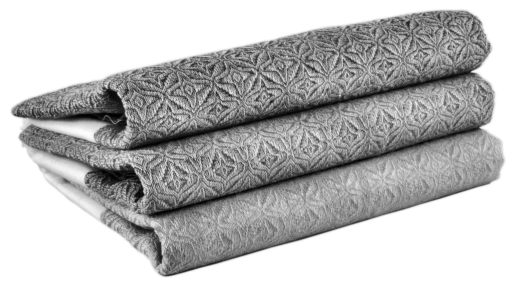

In [7]:
# Let's improve the contrast using Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_image = clahe.apply(gray)
imshow(cl_image)

In [8]:
# Detect keypoint features with SIFT
sift = cv2.SIFT_create()
kp = sift.detect(cl_image, None)
len(kp)

52368

Il y a énormément de keypoints. Regardons le nombre de keypoints qu'on obtient sur l'image initiale :

In [9]:
# Detect keypoint features with SIFT
kp = sift.detect(gray, None)
len(kp)

25445

Il en reste encore beaucoup trop. Floutons l'image pour réduire le nombre de keypoints :

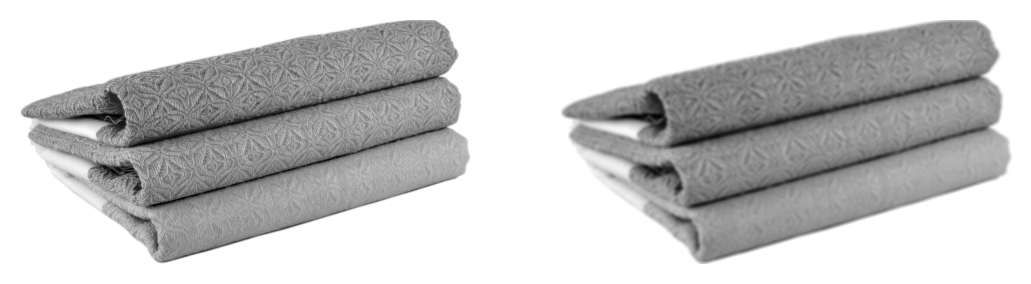

In [10]:
kernel = (20, 20)
blured = cv2.blur(gray, kernel)
plt.figure(dpi=200)
plt.subplot(121)
imshow(gray)
plt.subplot(122)
imshow(blured)

In [11]:
sift = cv2.SIFT_create()
kp = sift.detect(blured, None)
len(kp)

155

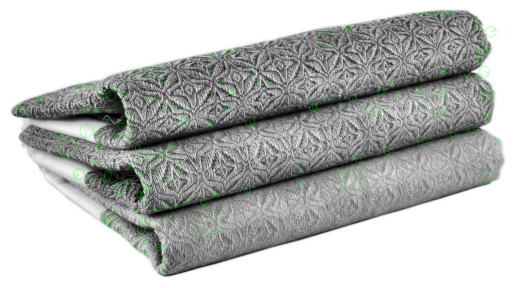

In [12]:
# kp, des = sift.detectAndCompute(blured, None)
img = cv2.drawKeypoints(cl_image, kp, cl_image, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img)

On ne voit pas grand chose avec la fonction `drawKeypoints` de OpenCV.
Construisons notre propre fonction pour mieux visualiser les keypoints :

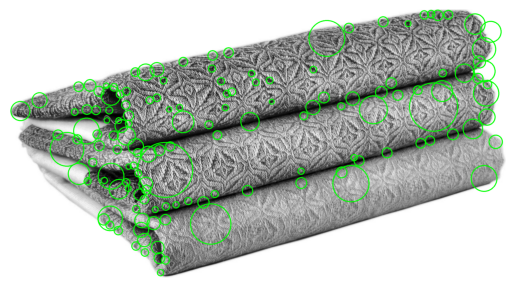

In [13]:
def drawKeypoints(image, keypoints, color=(0,255,0), thickness=3):
    img = image.copy()
    for keypoint in keypoints:
        x = np.uint16(keypoint.pt[0])
        y = np.uint16(keypoint.pt[1])
        size = np.uint16(keypoint.size)
        cv2.circle(img, (x,y), size, color, thickness=thickness, lineType=8, shift=0)
    imshow(img)
    # return image

cl_rgb = cv2.cvtColor(cl_image, cv2.COLOR_GRAY2RGB)
drawKeypoints(cl_rgb, kp, (0,255,0), 3)

### Applications sur plusieurs images

Appliquons les opérations précédentes sur plusieurs images et visualisons les résultats.

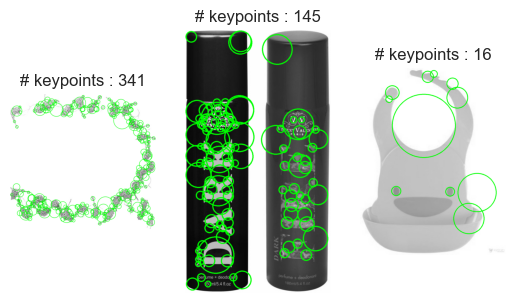

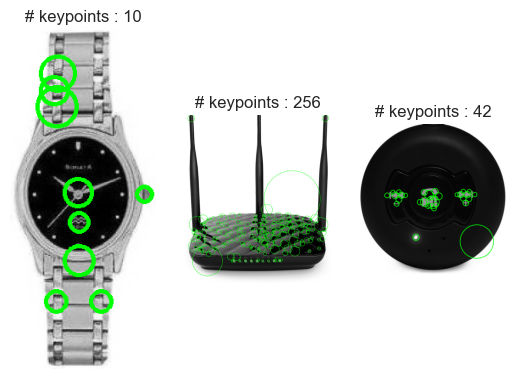

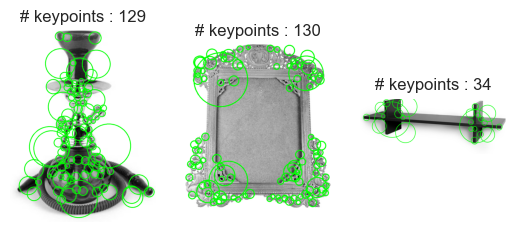

In [14]:
sift = cv2.SIFT_create()
blur_kernel = (20, 20)
i = 0
for path in df_images["image_path"].sample(9, random_state=9):
    if i%3 == 0:
        plt.figure()
    gray = cv2.imread(path, 0)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    gray_rgb.shape
    blured = cv2.blur(gray, blur_kernel)
    keypoints = sift.detect(blured, None)
    plt.subplot(130+(i%3)+1)
    plt.title(f"# keypoints : {len(keypoints)}")
    drawKeypoints(gray_rgb, keypoints, (0,255,0), 3)
    i += 1

## Extraction des descripteurs de toutes les images

### Créations des descripteurs de chaque image
* création d'une liste de descripteurs par image (``sift_descriptors_by_img``) qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images (``sift_descriptors_all``) qui sera utilisé pour créer les clusters de descripteurs

In [ ]:
# cell to stop the run
error

In [77]:
%%time
sift_descriptors = []
sift = cv2.SIFT_create(100) # maximum of 100 keypoints
blur_kernel = (20, 20)
for i in tqdm(range(df_images.shape[0])):
    gray = cv2.imread(df_images['image_path'].iloc[i], 0) # import image in grayscale
    blured = cv2.blur(gray, blur_kernel)
    kp, des = sift.detectAndCompute(blured, None)
    sift_descriptors.append(des)

100%|██████████| 1050/1050 [08:25<00:00,  2.08it/s] 


On va transformer la liste ``sift_descriptors`` en tableau numpy puis on va concaténer tous les éléments dans l'objet ``sift_descriptors_all``

In [135]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype='object')
sift_descriptors_by_img.shape

(1050,)

In [136]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 343 has 0 dimension(s)

On rencontre une erreur car l'élément se trouvant à l'index 343 est vide, cela signifie que l'algorithme SIFT n'a détecté aucun keypoints. Regardons cela de plus près.

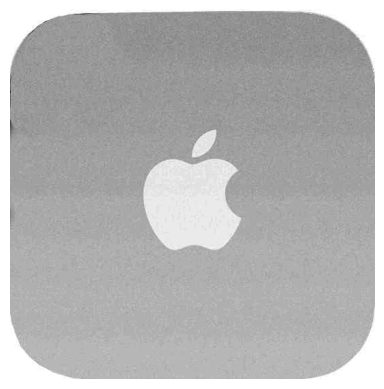

In [116]:
# Let's take a look at the image in question
index = 343
gray = cv2.imread(df_images['image_path'].iloc[index], 0)
imshow(gray)

In [217]:
gray.min(), gray.max()

(220, 255)

Let's increase the contrast by equalizing the image histogram and see if we can detect keypoints on the new image.

100

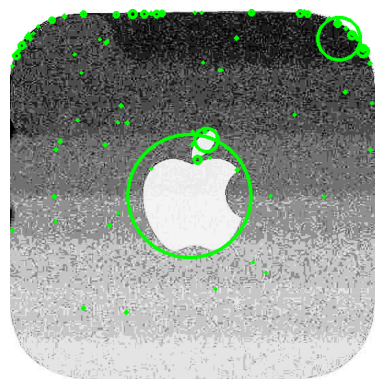

In [178]:
equ = cv2.equalizeHist(np.uint8(gray))
keypoints = sift.detect(equ, None)
equ_rgb = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
drawKeypoints(equ_rgb, kp, (0,255,0), 3)
len(kp)

Let's insert the image descriptors in ``sift_descriptors``.

In [195]:
kp, des = sift.compute(equ, keypoints)
sift_descriptors[index] = des
sift_descriptors[index].shape

(100, 128)

In [196]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype='object')
sift_descriptors_by_img.shape

(1050,)

In [200]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)
sift_descriptors_all.shape

(80828, 128)

There is a total of **80 828** descriptors across all images. Let's save them using ``pickle`` :

In [202]:
# # Save descriptors
# import pickle
# with open('data/sift_descriptors', 'wb') as fichier:
#     my_pickler = pickle.Pickler(fichier)
#     my_pickler.dump(sift_descriptors_by_img)

In [80]:
# # load descriptors
# import pickle
# with open('data/sift_descriptors', 'rb') as fichier:
#     my_unpickler = pickle.Unpickler(fichier)
#     sift_descriptors_by_img = my_unpickler.load()
# sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

### Création des clusters de descripteurs

On va regrouper les descripteurs en clusters à l'aide d'un algorithme de clustering.
Nous allons utiliser ``MiniBatchKMeans`` pour obtenir des temps de traitement raisonnables.

In [81]:
start = time.time()

k = round(np.sqrt(len(sift_descriptors_all)))
print("Nombre de clusters estimés :", k)

# Clustering
print(f"Création de {k} clusters de descripteurs ...")
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_descriptors_all)

end = time.time()
print("temps de traitement kmeans : %.2f secondes"%(end-start))

Nombre de clusters estimés : 284
Création de 284 clusters de descripteurs ...


c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


temps de traitement kmeans : 2.62 secondes


### Création des features des images

Pour chaque image, nous allons déterminer le cluster de chaque descripteur puis construire un histogramme représentant le nombre de descripteurs par cluster.

Nous considérerons les features d'une image comme étant l'histogramme correspondant à cette image, c'est-à-dire le nombre de descripteurs par cluster.

In [82]:
def build_histogram(kmeans, des, image_num):
    labels = kmeans.predict(des)
    hist = np.zeros(k)
    nb_des = len(des) # or des.shape[0]
    if nb_des == 0 : print("problème : pas de descripteur pour l'image :", image_num)
    for i in labels:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

# Creation of histograms (features)
start = time.time()
for i, image_desc in (enumerate(sift_descriptors_by_img)):
    #if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) # calculates the histogram
    hist_vectors.append(hist) # the histogram is the feature vector
im_features = np.asarray(hist_vectors)

end = time.time()
print("temps de création des histogrammes : %.2f secondes"% (end-start))
print("Dimensions de la matrices des histogrammes :", im_features.shape)

temps de création des histogrammes : 0.31 secondes
Dimensions de la matrices des histogrammes : (1050, 284)


### Réduction de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé
* L'impact est une meilleure séparation des données et une réduction du temps de traitement du t-SNE

In [89]:
print("Dimensions dataset avant réduction PCA :", im_features.shape)
pca = PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 284)
Dimensions dataset après réduction PCA : (1050, 191)


#### Réduction de dimension t-SNE

Réduction de dimension en 2 composantes t-SNE pour afficher les clusters en 2D

In [90]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['X_tsne1', 'X_tsne2'])
df_tsne["class"] = df_images["category"]
df_tsne.head()

X_tsne1    X_tsne2            class
0   5.727871  21.784243  Home Furnishing
1  20.195164  18.474737        Baby Care
2  23.958656   1.691640        Baby Care
3  -7.960743  19.015556  Home Furnishing
4   5.948412  -1.604988  Home Furnishing

### Analyse visuelle : affichage t-SNE selon les catégories d'images

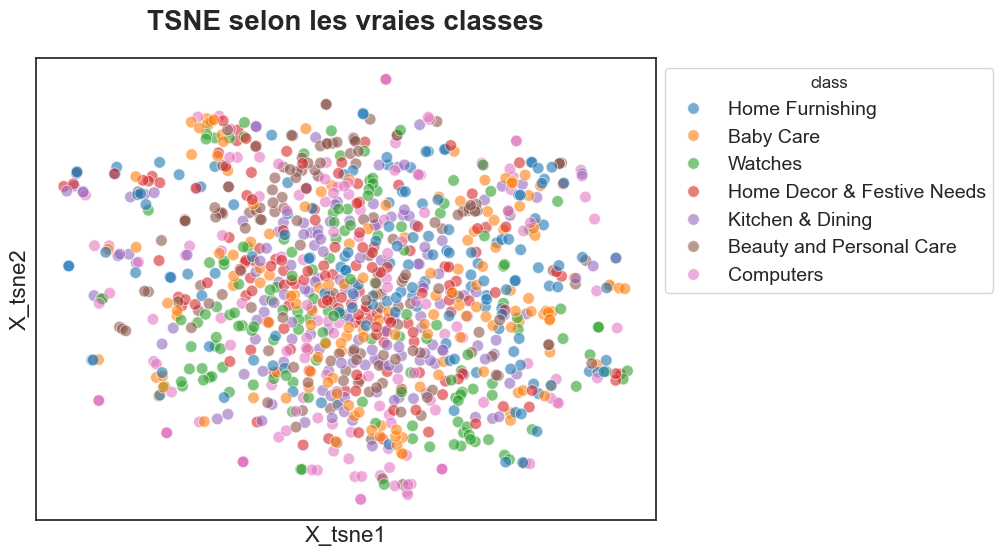

In [91]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="class", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=n_labels), s=70, alpha=0.6)

ax.set_title('TSNE selon les vraies classes', fontsize = 20, pad = 35, 
          fontweight = 'bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
#ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size':14})
ax.set_xticks([])
ax.set_yticks([])
#plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

Toutes les catégories sont mélangées, on ne voit pas grand chose...

### Mesure de similarité entre catégories et clusters

In [95]:
ARI, X_tsne, labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.02 duration :  7.6 s


Comme on pouvait s'y attendre, l'ARI est très mauvais. C'est dû au fait que les catégories ne sont pas séparées

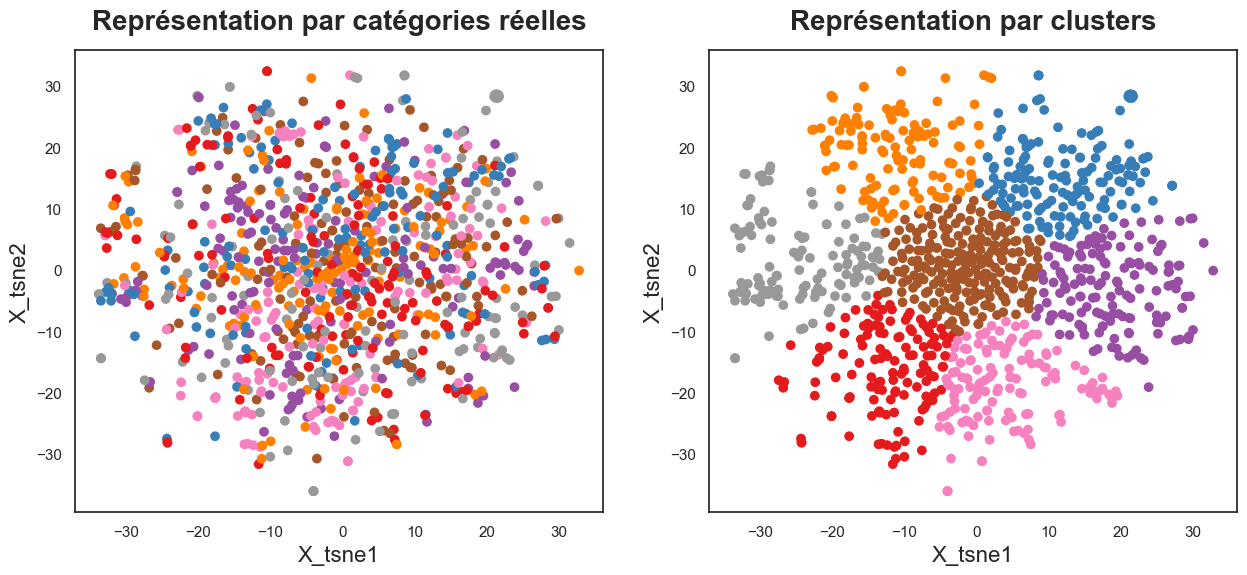

ARI :  0.02


In [100]:
TSNE_visu_fct(X_tsne, cat_labels, labels, categories, ARI,
              legend_loc='upper left',
              show_ticks=True,
              legend=False
              )

# Transfer Learning avec Keras

On va utiliser le modèle VGG-16 fourni par Keras et pré-entraîné sur ImageNet en enlevant la dernière couche, celle qui sert à faire la classification.

In [7]:
from keras.applications.vgg16 import VGG16
from keras import Model

# On charge le modèle VGG-16 pré-entraîné sur ImageNet
model = VGG16()

# On enlève la dernière couche
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Import des images

In [9]:
df_images = pd.read_csv('data/df_images.csv', index_col=0)
display(df_images.head())

image_path         category  label
0  ./data/images/55b85ea15a1536d46b7190ad6fff8ce7...  Home Furnishing      0
1  ./data/images/7b72c92c2f6c40268628ec5f14c6d590...        Baby Care      1
2  ./data/images/64d5d4a258243731dc7bbb1eef49ad74...        Baby Care      1
3  ./data/images/d4684dcdc759dd9cdf41504698d737d8...  Home Furnishing      0
4  ./data/images/6325b6870c54cd47be6ebfbffa620ec7...  Home Furnishing      0

Nous devons d'abord charger les images et les pré-traiter afin qu'elles respectent bien les spécifications des images en entrée de VGG-16.
Pour cela, nous allons utiliser les fonctions du module `keras.utils` et `keras.preprocessing.vgg16` :
1. VGG-16 reçoit des images de taille (224, 224, 3) : la fonction `load_img` permet de charger l'image et de la redimensionner correctement
2. Keras traite les images comme des tableaux numpy : `img_to_array` permet de convertir l'image chargée en tableau numpy
3. Le réseau doit recevoir en entrée une collection d'images, stockée dans un tableau à 4 dimensions, où les dimensions correspondent (dans l'ordre) à (nombre d'images, largeur, hauteur, profondeur).
4. Enfin, `preprocess_input` permet d'appliquer les mêmes pré-traitements que ceux utilisés lors du pré-entraînement.

Ainsi, on prépare l'image comme ci-dessous :

In [10]:
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# from PIL import Image
# Image.MAX_IMAGE_PIXELS = int(1e9) # increase maximum size of loaded images

images = []
for path in df_images['image_path']:
    img = load_img(path, target_size=(224, 224))  # charge l'image
    img = img_to_array(img)  # convertit en tableau numpy
    images.append(img)
images = np.array(images)

# Prétraitement de l'image comme le veut VGG-16
images = preprocess_input(images)
images.shape

c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

In [20]:
# Extraction des features
features = model.predict(images)
features.shape

33/33 [==============================] - 134s 4s/step


(1050, 4096)

## Réduction de dimension

### Réduction de dimension PCA

In [21]:
print("Dimensions dataset avant réduction PCA :", features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 4096)
Dimensions dataset après réduction PCA : (1050, 803)


### Réduction de dimension t-SNE

Réduction de dimension en 2 composantes t-SNE pour affichage en 2D des images

In [25]:
ARI, X_tsne, cls_labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.49 duration :  6.7 s


In [30]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(cls_labels, 1, 6)
switch(cls_labels, 2, 4)

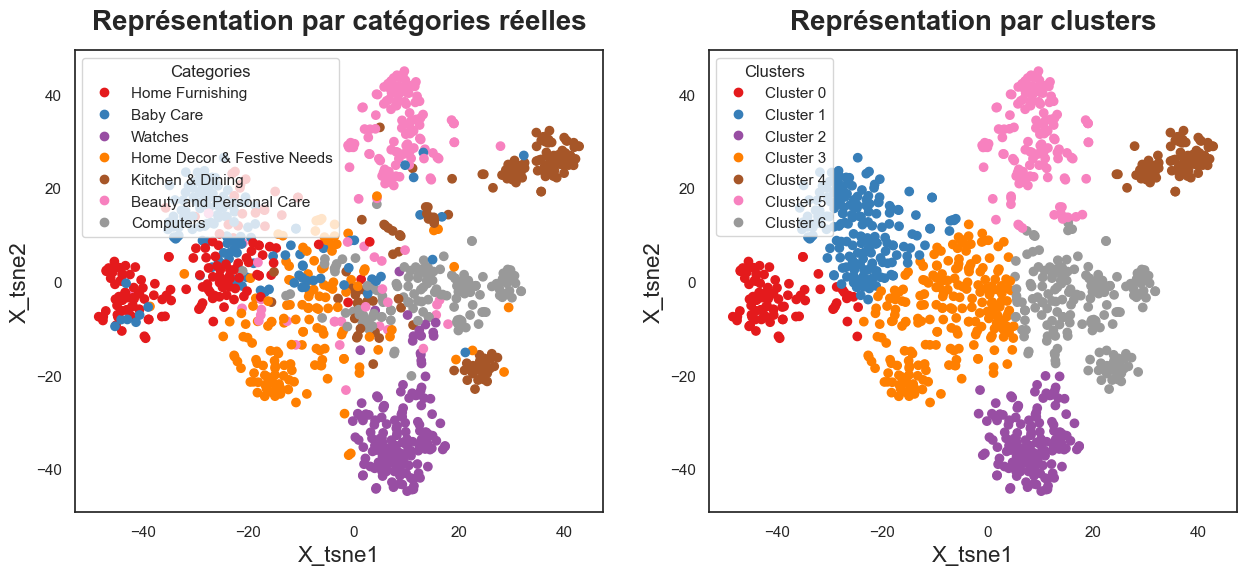

ARI :  0.49


In [31]:
TSNE_visu_fct(X_tsne, cat_labels, cls_labels, categories, ARI,
              legend_loc='upper left',
              show_ticks=True,
              legend=True
              )

## Matrice de confusion

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
conf_mat = confusion_matrix(cat_labels, cls_labels)
print(conf_mat)

[[ 78  64   0   8   0   0   0]
 [  7 112   0  22   1   5   3]
 [  0   0 134   2   0   0  14]
 [  3   8   3 126   0   1   9]
 [  0   0   0  20  78  15  37]
 [  1   3   1  16   1 118  10]
 [  0   1   1  29   0   1 118]]


On voit que les colonnes de la matrice de confusion ne sont pas ordonnées. On va définir une fonction de sorte à ce que les correspondances entre les vrais catégories et celles prédites se retrouvent sur la diagonale

In [37]:
print(classification_report(cat_labels, cls_labels))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65       150
           1       0.60      0.75      0.66       150
           2       0.96      0.89      0.93       150
           3       0.57      0.84      0.68       150
           4       0.97      0.52      0.68       150
           5       0.84      0.79      0.81       150
           6       0.62      0.79      0.69       150

    accuracy                           0.73      1050
   macro avg       0.78      0.73      0.73      1050
weighted avg       0.78      0.73      0.73      1050



<Axes: >

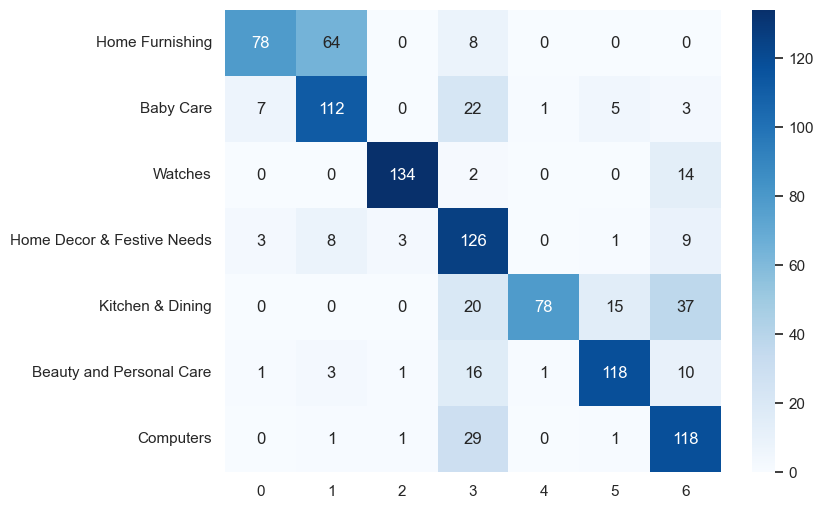

In [42]:
df_cm = pd.DataFrame(conf_mat,
                     index=categories,
                     columns=[i for i in range(n_labels)])
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

## Classification avec une régression logistique

Entraînons une régression logistique sur les features extraites puis réduites via ACP.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(feat_pca, cat_labels, test_size=0.2, random_state=2024)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

Results of the Logistic Regression :
Accuracy on training set : 1.000
Accuracy on validation set : 0.843


On voit que le modèle overfit.